# Training on Straming data with skmultiflow 

In [1]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd 
import numpy as np 
import datetime
import matplotlib.pyplot as plt
import glob
import itertools
from skmultiflow.data.data_stream import DataStream
from skmultiflow.meta import AdaptiveRandomForestClassifier, StreamingRandomPatchesClassifier,\
OnlineBoostingClassifier, OnlineSMOTEBaggingClassifier
from skmultiflow.evaluation import EvaluatePrequential
from sklearn.metrics import accuracy_score, f1_score,recall_score,precision_score,accuracy_score,roc_auc_score,confusion_matrix
%matplotlib notebook

# load training and test data, 5:3 ~ 60%:40%

In [2]:
file_paths = '..//preprocessed_data/Sebastian/Preprocessed_without_anchor/binary/'
filenames = glob.glob(file_paths+"*[0-9].csv",recursive = True)
list_of_dfs = [pd.read_csv(filename,sep=';',header=0) for filename in filenames]
data_all = pd.DataFrame()
for dataframe, filename in zip(list_of_dfs, filenames):
    data_all=data_all.append(dataframe.iloc[:,-5:])
data=pd.DataFrame(data_all)
data.reset_index(drop=True,inplace=True)
len(data)

113349

In [3]:
X_train=data.iloc[:,:4]
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
print(X_train,len(X_train))

[[-1.87468062 -1.62463649 -1.76747707 -1.58093731]
 [-1.39811827 -1.21677208 -1.40405661 -1.1140461 ]
 [-1.01091137 -0.84372536 -0.88875895 -0.61458108]
 ...
 [-0.13721373 -0.1225017  -0.27582595 -0.25084025]
 [-0.12232116 -0.12747566 -0.2541292  -0.26169818]
 [-0.12728535 -0.13244962 -0.2541292  -0.26169818]] 113349


In [4]:
file_paths = '..//data/processed/'
filenames = glob.glob(file_paths+"*[0-9].csv",recursive = True)
list_of_dfs = [pd.read_csv(filename,sep=';',header=0) for filename in filenames]
data_t_all = pd.DataFrame()
for dataframe, filename in zip(list_of_dfs, filenames):
    data_t_all=data_t_all.append(dataframe.iloc[:,-5:])
data_t=pd.DataFrame(data_t_all)
data_t.reset_index(drop=True,inplace=True)
len(data_t)

61300

In [5]:
X_test=data_t.iloc[:,:4]

# PCA Preprocessing

In [6]:
pca = PCA(n_components = 3)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

In [7]:
print(pca.explained_variance_ratio_)

[0.83712471 0.1547575  0.00649036]


In [8]:
X_train_pca_df = pd.DataFrame(data = X_train_pca, columns = ['pc1', 'pc2','pc3'])
X_test_pca_df = pd.DataFrame(data = X_test_pca, columns = ['pc1', 'pc2','pc3'])
final_df = pd.concat([X_train_pca_df.iloc[:,:2], data.label], axis = 1)
final_df

,pc1,pc2,label
0,-3.423868,-0.075527,0
1,-2.566504,-0.048483,0
2,-1.678996,-0.175731,0
3,-0.842111,-0.272217,0
4,-0.013394,-0.360562,0
...,...,...,...
113344,-0.495554,0.101668,0
113345,-0.439513,0.125135,0
113346,-0.393192,0.133468,0
113347,-0.382812,0.133017,0


In [9]:
test_df = pd.concat([X_test_pca_df.iloc[:,:2], data_t.label], axis = 1)
test_df

,pc1,pc2,label
0,-348.501341,329.485933,0
1,-396.501091,310.489518,0
2,-396.500215,350.484980,0
3,-364.501518,385.483675,0
4,-368.001489,357.985570,0
...,...,...,...
61295,-500.508335,3534.507570,0
61296,-743.525937,2712.480170,0
61297,46.930176,-73.334636,0
61298,2704.011282,-999.045224,0


<IPython.core.display.Javascript object>


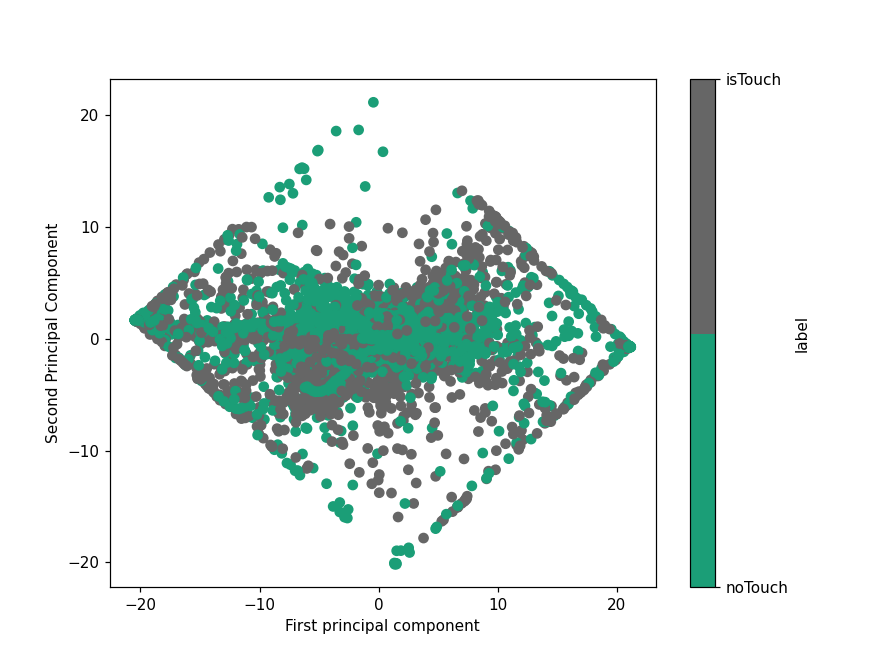

In [42]:
plt.figure(figsize=(8,6))
plt.scatter(final_df.pc1,final_df.pc2,c=final_df['label'],cmap=plt.cm.get_cmap('Dark2', 2))
plt.xlabel('First principal component')
plt.ylabel('Second Principal Component')
cbar=plt.colorbar(ticks=range(2), label='label')
cbar.ax.set_yticklabels(['noTouch',  'isTouch'])
plt.savefig('../reports/pca.png')

<IPython.core.display.Javascript object>


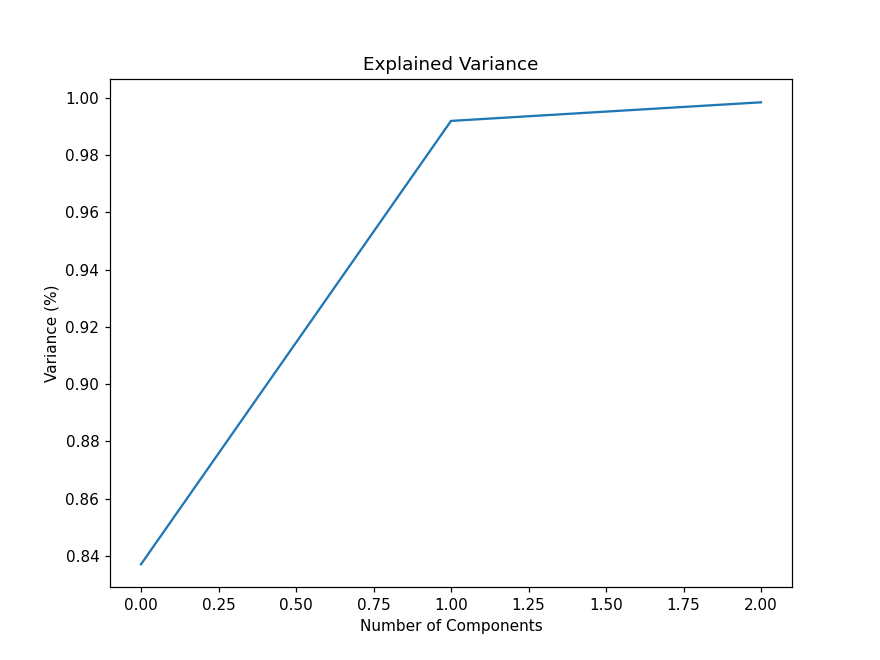

In [43]:
plt.figure(figsize=(8,6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') 
plt.title('Explained Variance')
plt.show()
plt.savefig('../reports/pca_select.png')

# train the final data on online-boosting-classifier with warm start

In [12]:
stream=DataStream(final_df)
stream.restart()
X, y = stream.next_sample(300)

In [13]:
online_boosting = OnlineBoostingClassifier()
online_boosting.fit(X,y,[0,1],[0.1,0.9])
y_pre = online_boosting.predict(X)
print('mean accuracy on warm start',online_boosting.score(X,y))

mean accuracy on warm start 0.9933333333333333


In [14]:
y_pre = online_boosting.predict(X)
acc = accuracy_score(y,y_pre)
f1 = f1_score(y, y_pre)
precision = precision_score(y, y_pre)
recall = recall_score(y, y_pre)
print('accuracy, f1, precison and recall on the first 300 training data as warm start\n',[acc,f1,precision,recall])

accuracy, f1, precison and recall on the first 300 training data as warm start
 [0.9933333333333333, 0.9444444444444444, 1.0, 0.8947368421052632]


In [15]:
print('prediction on the first 300 training data as warm start\n',y_pre)

prediction on the first 300 training data as warm start
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1]


In [16]:
partial_acc = []
partial_f1 = []
partial_recall = []
partial_precision = []
#partial_roc_auc = []
pred = []
y_true=[]
for i in range(int(stream.n_remaining_samples()/300)):
    
    # Receive new data instances X
    X_new, _ = stream.next_sample(300)
    
    # Compute predictions for new instances X
    y_predicted = online_boosting.predict(X_new)
    
    # ... some time passes ...
    
    # Reception of true labels for data instances X
    y_new = stream.current_sample_y
    
    # Compute the prediction accuracy
    current_accuracy = accuracy_score(y_new, y_predicted)
    current_f1 = f1_score(y_new, y_predicted)
    current_precision = precision_score(y_new, y_predicted)
    current_recall = recall_score(y_new, y_predicted)
    #current_roc_auc = roc_auc_score(y_new, y_predicted)
    partial_acc.append(current_accuracy)
    partial_f1.append(current_f1)
    partial_precision.append(current_precision)
    partial_recall.append(current_recall)
    #partial_roc_auc.append(current_roc_auc)
    pred = np.append(pred,y_predicted)
    y_true = np.append(y_true, y_new)
    #Update of the prediction model
    online_boosting.partial_fit(X_new,y_new,[0,1],[0.1,0.9])

/home/brooke/envs/p3_env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/home/brooke/envs/p3_env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/brooke/envs/p3_env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/brooke/envs/p3_env/lib/python3.6/site-packages/sklearn/metrics/_classificatio

/home/brooke/envs/p3_env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/brooke/envs/p3_env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/brooke/envs/p3_env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/brooke/envs/p3_env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: Un

/home/brooke/envs/p3_env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/brooke/envs/p3_env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/brooke/envs/p3_env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/brooke/envs/p3_env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1465: Un

/home/brooke/envs/p3_env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/brooke/envs/p3_env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/brooke/envs/p3_env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/brooke/envs/p3_env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedM

/home/brooke/envs/p3_env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/brooke/envs/p3_env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/brooke/envs/p3_env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/home/brooke/envs/p3_env/lib/python3.6/site-packages/sklearn/metrics/_classificatio

/home/brooke/envs/p3_env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/home/brooke/envs/p3_env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/brooke/envs/p3_env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/brooke/envs/p3_env/lib/python3.6/site-packages/sklearn/metrics/_classificatio

/home/brooke/envs/p3_env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/brooke/envs/p3_env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/brooke/envs/p3_env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/home/brooke/envs/p3_env/lib/python3.6/site-packages/sklearn/metrics/_classificatio

/home/brooke/envs/p3_env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/brooke/envs/p3_env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/brooke/envs/p3_env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/home/brooke/envs/p3_env/lib/python3.6/site-packages/sklearn/metrics/_classificatio

/home/brooke/envs/p3_env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/brooke/envs/p3_env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/brooke/envs/p3_env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/brooke/envs/p3_env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1465: Un

/home/brooke/envs/p3_env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/brooke/envs/p3_env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/brooke/envs/p3_env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/brooke/envs/p3_env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedM

/home/brooke/envs/p3_env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/brooke/envs/p3_env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/brooke/envs/p3_env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/brooke/envs/p3_env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: Un

/home/brooke/envs/p3_env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/brooke/envs/p3_env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/brooke/envs/p3_env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/brooke/envs/p3_env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1465: UndefinedM

/home/brooke/envs/p3_env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/home/brooke/envs/p3_env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/brooke/envs/p3_env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/brooke/envs/p3_env/lib/python3.6/site-packages/sklearn/metrics/_classificatio

/home/brooke/envs/p3_env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/home/brooke/envs/p3_env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/brooke/envs/p3_env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/brooke/envs/p3_env/lib/python3.6/site-packages/sklearn/metrics/_classificatio

/home/brooke/envs/p3_env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/brooke/envs/p3_env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/home/brooke/envs/p3_env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/brooke/envs/p3_env/lib/python3.6/site-packages/sklearn/metrics/_classificatio

<IPython.core.display.Javascript object>


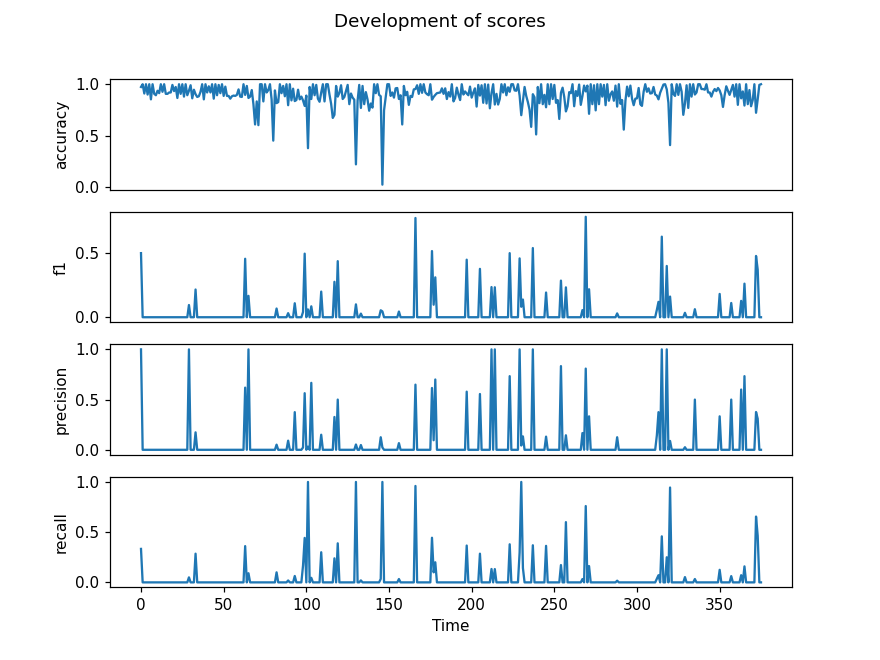

In [41]:
plt.figure(figsize=(8,6))
plt.subplot(411)
plt.plot(partial_acc,label ='accuracy')
plt.ylabel('accuracy')
plt.xticks([])
plt.subplot(412)
plt.plot(partial_f1,label ='f1')
plt.ylabel('f1')
plt.xticks([])
plt.subplot(413)
plt.plot(partial_precision,label ='precision')
plt.ylabel('precision')
plt.xticks([])
plt.subplot(414)
plt.plot(partial_recall,label ='recall')
#plt.subplot(515)
#plt.plot(partial_roc_auc,label ='roc_auc')
#plt.ylabel('roc_auc')
plt.xlabel('Time')
plt.ylabel('recall')
plt.suptitle('Development of scores')
#handles, labels = ax.get_legend_handles_labels()
#fig.legend(handles, labels, loc='upper center')
plt.show()
plt.savefig('../reports/train_onlineboosting.png')

In [18]:
scores=np.column_stack((partial_acc,partial_f1,partial_precision,partial_recall))
print('Mean scores [partial_acc,partial_f1,partial_precision,partial_recall]:', np.mean(scores, axis=0))

Mean scores [partial_acc,partial_f1,partial_precision,partial_recall]: [0.89569149 0.03462537 0.06254521 0.04329668]


# test on the transformed test data

In [19]:
test_stream=DataStream(test_df)
test_stream.restart()

In [20]:
X_test, y_test = test_stream.next_sample(len(test_df))
online_boosting.score(X_test, y_test)

0.6601305057096248

In [21]:
y_pred=online_boosting.predict(X_test)

In [22]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.xlim(-0.5, len(np.unique(y))-0.5)
    plt.ylim(len(np.unique(y))-0.5, -0.5)
    return ax

Normalized confusion matrix
[[0.71007532 0.28992468]
 [0.62083874 0.37916126]]


<IPython.core.display.Javascript object>


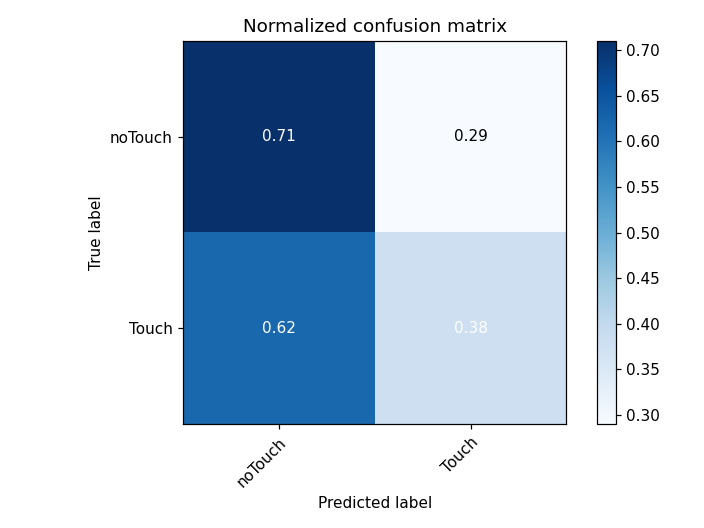

In [39]:
class_names=['noTouch','Touch']
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.savefig('../reports/cm_onlineboosting.png')

In [24]:
def plot_pred(y, pred):
    plt.figure()
    plt.plot(pred, 'rx',label ='prediction')
    plt.plot(y,'b.', label='target')
    plt.title('Development of prediction vs. target')
    plt.xlabel('Time')
    plt.ylabel('categoray')
    plt.legend(loc='lower right', bbox_to_anchor=(0.5, 0.8, 0.5, 0.5))
    plt.show()

<IPython.core.display.Javascript object>


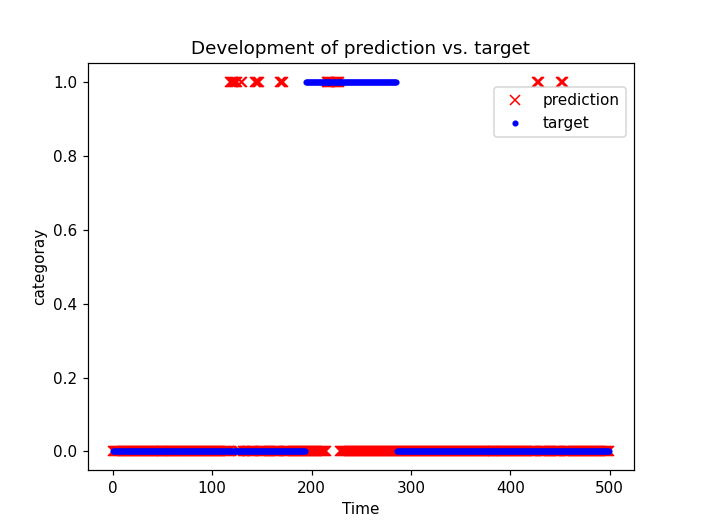

In [40]:
plot_pred(y_test[60000:60500], y_pred[60000:60500])
plt.savefig('../reports/testdemo.png')

In [26]:
print("accuracy: ",accuracy_score(y_test, y_pred))
print("f1 score: ",f1_score(y_test, y_pred))     
print( "precision score: ",precision_score(y_test, y_pred) )
print( "recall score: ",recall_score(y_test, y_pred))

accuracy:  0.6601305057096248
f1 score:  0.25192100538599643
precision score:  0.18862243251962577
recall score:  0.3791612624297449


In [28]:
#save the trained model for reuse
import pickle
modelfilename = '../reports/finalized_model.pkl'
with open(modelfilename, 'wb') as file:  
    pickle.dump(online_boosting, file)

with open(modelfilename, 'rb') as f:
    model = pickle.load(f)


In [29]:
y_demo=model.predict(X_test[2000:2600])
y_demo

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,